In [2]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import os
import matplotlib.pyplot as plt


In [1]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import os

# Define the parameters
short_city=['Si','Ro','Mi']
long_city=['Siracusa','Roma','Milano']
scenario='Inc2025'

for c in range(3):
    city=short_city[c]
    city_extended=long_city[c]
    csv_folder=f'{city_extended}/Results_csv'
    cost_op_tot_all = pd.read_csv(f'{csv_folder}/cost_op_tot.csv',usecols=lambda column: column != 'id')
    active_techs_all = pd.read_csv(f'{csv_folder}/active_techs.csv',usecols=lambda column: column != 'id')
    cap_tot_all = pd.read_csv(f'{csv_folder}/cap_tot.csv',usecols=lambda column: column != 'id')
    new_units_all = pd.read_csv(f'{csv_folder}/new_units.csv',usecols=lambda column: column != 'id')
    cap_new_all = pd.read_csv(f'{csv_folder}/cap_new.csv',usecols=lambda column: column != 'id')
    CO2_tot_all = pd.read_csv(f'{csv_folder}/CO2_tot.csv',usecols=lambda column: column != 'id')
    CO2_act_all = pd.read_csv(f'{csv_folder}/CO2_act.csv',usecols=lambda column: column != 'id')
    insulation_all = pd.read_csv(f'{csv_folder}/insulation.csv',usecols=lambda column: column != 'id')
    X_all = pd.read_csv(f'{csv_folder}/X.csv',usecols=lambda column: column != 'id')
    Xt_all = pd.read_csv(f'{csv_folder}/X_t.csv',usecols=lambda column: column != 'id')
    Q_all = pd.read_csv(f'{csv_folder}/Q.csv',usecols=lambda column: column != 'id')
    SOC_all = pd.read_csv(f'{csv_folder}/SOC.csv',usecols=lambda column: column != 'id')
    # Importing exogenous data from data_input excel
    excel_file = f'{city_extended}/input_data/input_data.xlsx'
    Y_all = pd.read_excel(excel_file, sheet_name='Y',usecols=lambda column: column != 'id')
    cost_cap = pd.read_excel(excel_file, sheet_name='cost_cap',usecols=lambda column: column != 'id')
    cost_period = pd.read_excel(excel_file, sheet_name='cost_period',usecols=lambda column: column != 'id')
    cost_inv_all = pd.read_excel(excel_file, sheet_name='cost_inv',usecols=lambda column: column != 'id')
    disc_frac_pd = pd.read_excel(excel_file, sheet_name='disc_frac',usecols=lambda column: column != 'id')
    disc_frac=disc_frac_pd.at[0,'values']
    TI_cost_all = pd.read_excel(excel_file, sheet_name='TI_cost',usecols=lambda column: column != 'id')
    DPT = pd.read_excel(excel_file, sheet_name='days_per_type',usecols=lambda column: column != 'id')
    

    for user in ['A','B','C','D']:
        user_name=f'User{user}'
        scenario_name=f'{scenario}_{city}_{user}'
        #Selecting for specific user (letter)
        cost_op_tot=cost_op_tot_all.loc[cost_op_tot_all['s_names'] == f'User{user}']
        active_techs=active_techs_all.loc[active_techs_all['s_names'] == f'User{user}']
        cap_tot=cap_tot_all.loc[cap_tot_all['s_names'] == f'User{user}']
        new_units=new_units_all.loc[new_units_all['s_names'] == f'User{user}']
        cap_new=cap_new_all.loc[cap_new_all['s_names'] == f'User{user}']
        CO2_tot=CO2_tot_all.loc[CO2_tot_all['s_names'] == f'User{user}']
        CO2_act=CO2_act_all.loc[CO2_act_all['s_names'] == f'User{user}']
        insulation=insulation_all.loc[insulation_all['s_names'] == f'User{user}']
        X=X_all.loc[X_all['s_names'] == f'User{user}']
        Xt=Xt_all.loc[Xt_all['s_names'] == f'User{user}']
        Q=Q_all.loc[Q_all['s_names'] == f'User{user}']
        SOC=SOC_all.loc[SOC_all['s_names'] == f'User{user}']
        Y=Y_all.loc[Y_all['s_names'] == f'User{user}']
        cost_inv=cost_inv_all.loc[cost_inv_all['s_names'] == f'User{user}']
        TI_cost=TI_cost_all.loc[TI_cost_all['s_names'] == f'User{user}']

        for df in [cost_op_tot, active_techs, cap_tot, new_units, cap_new, CO2_tot, CO2_act, insulation, X, Xt, Q, SOC, Y, cost_inv, TI_cost]:
            df.reset_index(drop=True, inplace=True)

        #Definitions for time
        seasons = ['wi', 'mc', 'mw', 'su']
        season_names = {'wi': 'Winter', 'mc': 'Mid-cold', 'mw': 'Mid-warm', 'su': 'Summer'}

        #Isolate peak
        peak_Y= Y[Y['th_names'] == 'peak']
        Y=Y[Y['th_names'] != 'peak']
        peak_Q= Q[Q['th_names'] == 'peak']
        Q=Q[Q['th_names'] != 'peak']
        peak_X=X[X['th_names'] == 'peak']
        X=X[X['th_names'] != 'peak']
        peak_Xt=Xt[Xt['th_names'] == 'peak']
        Xt=Xt[Xt['th_names'] != 'peak']
        SOC=SOC[SOC['th_names'] != 'peak']
        DPT=DPT[DPT['days_names'] != 'peak']

        for db in [Y,Q,X,Xt,SOC]:
            db.index=range(len(db))
            db.loc[:,'season']=db['th_names'].str[4:6]
            db['hour'] = db['th_names'].str[1:3].astype(int)
            db['day'] = db['th_names'].str[-2:].astype(int)
            db['time'] = (db['day'] - 1) * 24 + db['hour']

        #Defining values to export in results.xlsx
        activity_costs=sum(cost_op_tot['values'])
        periodic_costs=sum((cost_period['values']+(cost_cap['values']*cap_tot['values']))*active_techs['values'])
        bill_one_year=activity_costs+periodic_costs
        operation_costs_discounted=bill_one_year*(sum(disc_frac ** x for x in range(1, 11)))
        investment_costs=sum(cost_inv['values']*new_units['values'])
        NPC=operation_costs_discounted+investment_costs

        cost_EE_period=cost_period.loc[cost_period['t_names']=='National Grid EE']['values'].values[0]+cost_cap.loc[cost_cap['t_names']=='National Grid EE']['values'].values[0]*cap_tot.loc[cap_tot['t_names']=='National Grid EE']['values'].values[0]
        cost_EE=cost_op_tot.loc[cost_op_tot['a_names']=='National Grid import']['values'].values[0]+cost_op_tot.loc[cost_op_tot['a_names']=='National Grid export']['values'].values[0]+cost_EE_period

        cost_NG_period=active_techs[active_techs['t_names']=='Gas National Grid']['values'].values[0]*cost_period.loc[cost_period['t_names']=='Gas National Grid']['values'].values[0]+cost_cap.loc[cost_cap['t_names']=='Gas National Grid']['values'].values[0]*cap_tot.loc[cap_tot['t_names']=='Gas National Grid']['values'].values[0]
        cost_NG=cost_op_tot.loc[cost_op_tot['a_names']=='Natural Gas supply grid']['values'].values[0]+cost_NG_period

        def compute_daily(df):
            #Group by day and season
            df = df.groupby(['day', 'season']).agg(consumption=('values', 'sum')).reset_index()
            #Fix the order
            season_order = ['wi', 'mc', 'mw', 'su']
            df['season'] = pd.Categorical(df['season'], categories=season_order, ordered=True)
            df_sorted = df.sort_values(by=['season', 'day'])
            df_sorted.index = range(len(df_sorted))
            return df_sorted

        Q_EE=Q[Q['n_names']=='EE']
        Q_EE_daily = compute_daily(Q_EE)
        Q_EE_daily['consumption'] = Q_EE_daily['consumption']*DPT['values']
        Q_EE_tot=sum(Q_EE_daily['consumption'])

        X_EE_daily = compute_daily(X[X['a_names']=='National Grid import'])
        X_EE_daily['consumption'] = X_EE_daily['consumption']*DPT['values']

        PV_prod=X[X['a_names']=='PV']
        X_PV_daily = compute_daily(PV_prod)
        X_PV_daily['consumption'] = X_PV_daily['consumption']*DPT['values']

        PV_sell=X[X['a_names']=='National Grid export']
        X_sell_daily = compute_daily(PV_sell)
        X_sell_daily['consumption'] = X_sell_daily['consumption']*DPT['values']

        Q_NG_daily = compute_daily(Q[Q['n_names']=='Natural Gas'])
        Q_NG_tot=sum(Q_NG_daily['consumption']*DPT['values'])

        # BEGIN: Update folder name
        new_folder = f'{city_extended}/{scenario}_Results_csv'
        if os.path.exists(csv_folder):
            os.rename(csv_folder, new_folder)
        #else:
        #    os.makedirs(new_folder)

        #Exporting results for this case
        results=pd.DataFrame(columns=['city','size','NPC','opex','capex','PV','GridEE','StorageEE','GasBoiler','HP','AC','StorageHW','Radiators','Floor_heat','Induction','GasStove','Q_EE','Q_NG','EE_in','EE_out','EE_PV','cash_EEin','cash_EEout','cash_EEtot','cash_NGin','cash_NGtot','CO2'])

        results.at[scenario_name,'city']=city_extended
        results.at[scenario_name,'size']=user
        results.at[scenario_name,'NPC']=round(NPC,2)
        results.at[scenario_name,'opex']=round(bill_one_year,2)
        results.at[scenario_name,'capex']=round(investment_costs,2)
        results.at[scenario_name,'PV']=round(cap_new.loc[cap_new['t_names']=='PV sys']['values'].values[0],2)
        results.at[scenario_name,'GridEE']=round(cap_tot.loc[cap_tot['t_names']=='National Grid EE']['values'].values[0],2)
        results.at[scenario_name,'StorageEE']=round(cap_tot.loc[cap_tot['t_names']=='Storage EE']['values'].values[0],2)
        results.at[scenario_name,'GasBoiler']=round(cap_tot.loc[cap_tot['t_names']=='Gas Boiler']['values'].values[0],2)
        results.at[scenario_name,'HP']=round(cap_tot.loc[cap_tot['t_names']=='HP']['values'].values[0],2)
        results.at[scenario_name,'AC']=round(cap_tot.loc[cap_tot['t_names']=='AC']['values'].values[0],2)
        results.at[scenario_name,'StorageHW']=round(cap_tot.loc[cap_tot['t_names']=='Storage HW']['values'].values[0],2)
        results.at[scenario_name,'Radiators']=round(cap_tot.loc[cap_tot['t_names']=='Radiators']['values'].values[0],2)
        results.at[scenario_name,'Floor_heat']=round(cap_tot.loc[cap_tot['t_names']=='Floor heating']['values'].values[0],2)
        results.at[scenario_name,'Induction']=round(cap_tot.loc[cap_tot['t_names']=='Induction stove']['values'].values[0],2)
        results.at[scenario_name,'GasStove']=round(cap_tot.loc[cap_tot['t_names']=='Gas stove']['values'].values[0],2)
        results.at[scenario_name,'Q_EE']=round(Q_EE_tot,2)
        results.at[scenario_name,'Q_NG']=round(Q_NG_tot,2)
        results.at[scenario_name,'EE_in']=round(sum(X_EE_daily['consumption']),2)
        results.at[scenario_name,'EE_out']=round(sum(X_sell_daily['consumption']),2)
        results.at[scenario_name,'EE_PV']=round(sum(X_PV_daily['consumption']),2)
        results.at[scenario_name,'cash_EEin']=round(cost_op_tot.loc[cost_op_tot['a_names']=='National Grid import']['values'].values[0],2)
        results.at[scenario_name,'cash_EEout']=round(cost_op_tot.loc[cost_op_tot['a_names']=='National Grid export']['values'].values[0],2)
        results.at[scenario_name,'cash_EEtot']=round(cost_EE,2)
        results.at[scenario_name,'cash_NGin']=round(cost_op_tot.loc[cost_op_tot['a_names']=='Natural Gas supply grid']['values'].values[0],2)
        results.at[scenario_name,'cash_NGtot']=round(cost_NG,2)
        results.at[scenario_name,'CO2']=round(CO2_tot.iloc[0]['values'],4)

        file_path = "/Users/cami/Documents/GitHub/pyesm_thesis/tesi_camilla/casi_MarioU/results_database.xlsx"  # Sostituisci con il percorso corretto del file
        book = load_workbook(file_path)
        # Trova l'ultima riga occupata nel foglio
        sheet_name = "EE+NG"
        sheet = book[sheet_name]
        last_row = sheet.max_row

        # Scrivi i dati usando l'ExcelWriter in modalità append
        with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
            results.to_excel(writer, sheet_name=sheet_name, index=True, header=False, startrow=last_row)

Complete run of multiple scenarios for EE GG scenarios

In [8]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import os

# Define the parameters
short_city=['Si','Ro','Mi']
long_city=['Siracusa','Roma','Milano']


for e in range(1,4):
    for g in range(1,4):
        scenario=f'E{e}G{g}'
        if scenario!='E2G2':   
            for c in range(3):
                city=short_city[c]
                city_extended=long_city[c]
                csv_folder=f'Sensitivity_EE_NG/{city_extended}/Results_EE_NG/{scenario}_Results_csv'
                cost_op_tot_all = pd.read_csv(f'{csv_folder}/cost_op_tot.csv',usecols=lambda column: column != 'id')
                active_techs_all = pd.read_csv(f'{csv_folder}/active_techs.csv',usecols=lambda column: column != 'id')
                cap_tot_all = pd.read_csv(f'{csv_folder}/cap_tot.csv',usecols=lambda column: column != 'id')
                new_units_all = pd.read_csv(f'{csv_folder}/new_units.csv',usecols=lambda column: column != 'id')
                cap_new_all = pd.read_csv(f'{csv_folder}/cap_new.csv',usecols=lambda column: column != 'id')
                CO2_tot_all = pd.read_csv(f'{csv_folder}/CO2_tot.csv',usecols=lambda column: column != 'id')
                CO2_act_all = pd.read_csv(f'{csv_folder}/CO2_act.csv',usecols=lambda column: column != 'id')
                insulation_all = pd.read_csv(f'{csv_folder}/insulation.csv',usecols=lambda column: column != 'id')
                X_all = pd.read_csv(f'{csv_folder}/X.csv',usecols=lambda column: column != 'id')
                Xt_all = pd.read_csv(f'{csv_folder}/X_t.csv',usecols=lambda column: column != 'id')
                Q_all = pd.read_csv(f'{csv_folder}/Q.csv',usecols=lambda column: column != 'id')
                SOC_all = pd.read_csv(f'{csv_folder}/SOC.csv',usecols=lambda column: column != 'id')
                # Importing exogenous data from data_input excel
                excel_file = f'Sensitivity_EE_NG/{city_extended}/input_data/input_data_{scenario}.xlsx'
                Y_all = pd.read_excel(excel_file, sheet_name='Y',usecols=lambda column: column != 'id')
                cost_cap = pd.read_excel(excel_file, sheet_name='cost_cap',usecols=lambda column: column != 'id')
                cost_period = pd.read_excel(excel_file, sheet_name='cost_period',usecols=lambda column: column != 'id')
                cost_inv_all = pd.read_excel(excel_file, sheet_name='cost_inv',usecols=lambda column: column != 'id')
                disc_frac_pd = pd.read_excel(excel_file, sheet_name='disc_frac',usecols=lambda column: column != 'id')
                disc_frac=disc_frac_pd.at[0,'values']
                TI_cost_all = pd.read_excel(excel_file, sheet_name='TI_cost',usecols=lambda column: column != 'id')
                DPT = pd.read_excel(excel_file, sheet_name='days_per_type',usecols=lambda column: column != 'id')
                

                for user in ['A','B','C','D']:
                    user_name=f'User{user}'
                    scenario_name=f'{scenario}_{city}_{user}'
                    #Selecting for specific user (letter)
                    cost_op_tot=cost_op_tot_all.loc[cost_op_tot_all['s_names'] == f'User{user}']
                    active_techs=active_techs_all.loc[active_techs_all['s_names'] == f'User{user}']
                    cap_tot=cap_tot_all.loc[cap_tot_all['s_names'] == f'User{user}']
                    new_units=new_units_all.loc[new_units_all['s_names'] == f'User{user}']
                    cap_new=cap_new_all.loc[cap_new_all['s_names'] == f'User{user}']
                    CO2_tot=CO2_tot_all.loc[CO2_tot_all['s_names'] == f'User{user}']
                    CO2_act=CO2_act_all.loc[CO2_act_all['s_names'] == f'User{user}']
                    insulation=insulation_all.loc[insulation_all['s_names'] == f'User{user}']
                    X=X_all.loc[X_all['s_names'] == f'User{user}']
                    Xt=Xt_all.loc[Xt_all['s_names'] == f'User{user}']
                    Q=Q_all.loc[Q_all['s_names'] == f'User{user}']
                    SOC=SOC_all.loc[SOC_all['s_names'] == f'User{user}']
                    Y=Y_all.loc[Y_all['s_names'] == f'User{user}']
                    cost_inv=cost_inv_all.loc[cost_inv_all['s_names'] == f'User{user}']
                    TI_cost=TI_cost_all.loc[TI_cost_all['s_names'] == f'User{user}']

                    for df in [cost_op_tot, active_techs, cap_tot, new_units, cap_new, CO2_tot, CO2_act, insulation, X, Xt, Q, SOC, Y, cost_inv, TI_cost]:
                        df.reset_index(drop=True, inplace=True)

                    #Definitions for time
                    seasons = ['wi', 'mc', 'mw', 'su']
                    season_names = {'wi': 'Winter', 'mc': 'Mid-cold', 'mw': 'Mid-warm', 'su': 'Summer'}

                    #Isolate peak
                    peak_Y= Y[Y['th_names'] == 'peak']
                    Y=Y[Y['th_names'] != 'peak']
                    peak_Q= Q[Q['th_names'] == 'peak']
                    Q=Q[Q['th_names'] != 'peak']
                    peak_X=X[X['th_names'] == 'peak']
                    X=X[X['th_names'] != 'peak']
                    peak_Xt=Xt[Xt['th_names'] == 'peak']
                    Xt=Xt[Xt['th_names'] != 'peak']
                    SOC=SOC[SOC['th_names'] != 'peak']
                    DPT=DPT[DPT['days_names'] != 'peak']

                    for db in [Y,Q,X,Xt,SOC]:
                        db.index=range(len(db))
                        db.loc[:,'season']=db['th_names'].str[4:6]
                        db['hour'] = db['th_names'].str[1:3].astype(int)
                        db['day'] = db['th_names'].str[-2:].astype(int)
                        db['time'] = (db['day'] - 1) * 24 + db['hour']

                    #Defining values to export in results.xlsx
                    activity_costs=sum(cost_op_tot['values'])
                    periodic_costs=sum((cost_period['values']+(cost_cap['values']*cap_tot['values']))*active_techs['values'])
                    bill_one_year=activity_costs+periodic_costs
                    operation_costs_discounted=bill_one_year*(sum(disc_frac ** x for x in range(1, 11)))
                    investment_costs=sum(cost_inv['values']*new_units['values'])
                    NPC=operation_costs_discounted+investment_costs

                    cost_EE_period=cost_period.loc[cost_period['t_names']=='National Grid EE']['values'].values[0]+cost_cap.loc[cost_cap['t_names']=='National Grid EE']['values'].values[0]*cap_tot.loc[cap_tot['t_names']=='National Grid EE']['values'].values[0]
                    cost_EE=cost_op_tot.loc[cost_op_tot['a_names']=='National Grid import']['values'].values[0]+cost_op_tot.loc[cost_op_tot['a_names']=='National Grid export']['values'].values[0]+cost_EE_period

                    cost_NG_period=active_techs[active_techs['t_names']=='Gas National Grid']['values'].values[0]*cost_period.loc[cost_period['t_names']=='Gas National Grid']['values'].values[0]+cost_cap.loc[cost_cap['t_names']=='Gas National Grid']['values'].values[0]*cap_tot.loc[cap_tot['t_names']=='Gas National Grid']['values'].values[0]
                    cost_NG=cost_op_tot.loc[cost_op_tot['a_names']=='Natural Gas supply grid']['values'].values[0]+cost_NG_period

                    def compute_daily(df):
                        #Group by day and season
                        df = df.groupby(['day', 'season']).agg(consumption=('values', 'sum')).reset_index()
                        #Fix the order
                        season_order = ['wi', 'mc', 'mw', 'su']
                        df['season'] = pd.Categorical(df['season'], categories=season_order, ordered=True)
                        df_sorted = df.sort_values(by=['season', 'day'])
                        df_sorted.index = range(len(df_sorted))
                        return df_sorted

                    Q_EE=Q[Q['n_names']=='EE']
                    Q_EE_daily = compute_daily(Q_EE)
                    Q_EE_daily['consumption'] = Q_EE_daily['consumption']*DPT['values']
                    Q_EE_tot=sum(Q_EE_daily['consumption'])

                    X_EE_daily = compute_daily(X[X['a_names']=='National Grid import'])
                    X_EE_daily['consumption'] = X_EE_daily['consumption']*DPT['values']

                    PV_prod=X[X['a_names']=='PV']
                    X_PV_daily = compute_daily(PV_prod)
                    X_PV_daily['consumption'] = X_PV_daily['consumption']*DPT['values']

                    PV_sell=X[X['a_names']=='National Grid export']
                    X_sell_daily = compute_daily(PV_sell)
                    X_sell_daily['consumption'] = X_sell_daily['consumption']*DPT['values']

                    Q_NG_daily = compute_daily(Q[Q['n_names']=='Natural Gas'])
                    Q_NG_tot=sum(Q_NG_daily['consumption']*DPT['values'])

                    # BEGIN: Update folder name
                    # new_folder = f'{city_extended}/{scenario}_Results_csv'
                    # if os.path.exists(csv_folder):
                    #     os.rename(csv_folder, new_folder)
                    # #else:
                    #    os.makedirs(new_folder)

                    #Exporting results for this case
                    results=pd.DataFrame(columns=['city','size','NPC','opex','capex','PV','GridEE','StorageEE','GasBoiler','HP','AC','StorageHW','Radiators','Floor_heat','Induction','GasStove','Q_EE','Q_NG','EE_in','EE_out','EE_PV','cash_EEin','cash_EEout','cash_EEtot','cash_NGin','cash_NGtot','CO2'])

                    results.at[scenario_name,'city']=city_extended
                    results.at[scenario_name,'size']=user
                    results.at[scenario_name,'NPC']=round(NPC,2)
                    results.at[scenario_name,'opex']=round(bill_one_year,2)
                    results.at[scenario_name,'capex']=round(investment_costs,2)
                    results.at[scenario_name,'PV']=round(cap_new.loc[cap_new['t_names']=='PV sys']['values'].values[0],2)
                    results.at[scenario_name,'GridEE']=round(cap_tot.loc[cap_tot['t_names']=='National Grid EE']['values'].values[0],2)
                    results.at[scenario_name,'StorageEE']=round(cap_tot.loc[cap_tot['t_names']=='Storage EE']['values'].values[0],2)
                    results.at[scenario_name,'GasBoiler']=round(cap_tot.loc[cap_tot['t_names']=='Gas Boiler']['values'].values[0],2)
                    results.at[scenario_name,'HP']=round(cap_tot.loc[cap_tot['t_names']=='HP']['values'].values[0],2)
                    results.at[scenario_name,'AC']=round(cap_tot.loc[cap_tot['t_names']=='AC']['values'].values[0],2)
                    results.at[scenario_name,'StorageHW']=round(cap_tot.loc[cap_tot['t_names']=='Storage HW']['values'].values[0],2)
                    results.at[scenario_name,'Radiators']=round(cap_tot.loc[cap_tot['t_names']=='Radiators']['values'].values[0],2)
                    results.at[scenario_name,'Floor_heat']=round(cap_tot.loc[cap_tot['t_names']=='Floor heating']['values'].values[0],2)
                    results.at[scenario_name,'Induction']=round(cap_tot.loc[cap_tot['t_names']=='Induction stove']['values'].values[0],2)
                    results.at[scenario_name,'GasStove']=round(cap_tot.loc[cap_tot['t_names']=='Gas stove']['values'].values[0],2)
                    results.at[scenario_name,'Q_EE']=round(Q_EE_tot,2)
                    results.at[scenario_name,'Q_NG']=round(Q_NG_tot,2)
                    results.at[scenario_name,'EE_in']=round(sum(X_EE_daily['consumption']),2)
                    results.at[scenario_name,'EE_out']=round(sum(X_sell_daily['consumption']),2)
                    results.at[scenario_name,'EE_PV']=round(sum(X_PV_daily['consumption']),2)
                    results.at[scenario_name,'cash_EEin']=round(cost_op_tot.loc[cost_op_tot['a_names']=='National Grid import']['values'].values[0],2)
                    results.at[scenario_name,'cash_EEout']=round(cost_op_tot.loc[cost_op_tot['a_names']=='National Grid export']['values'].values[0],2)
                    results.at[scenario_name,'cash_EEtot']=round(cost_EE,2)
                    results.at[scenario_name,'cash_NGin']=round(cost_op_tot.loc[cost_op_tot['a_names']=='Natural Gas supply grid']['values'].values[0],2)
                    results.at[scenario_name,'cash_NGtot']=round(cost_NG,2)
                    results.at[scenario_name,'CO2']=round(CO2_tot.iloc[0]['values'],4)

                    file_path = "/Users/cami/Documents/GitHub/pyesm_thesis/tesi_camilla/casi_MarioU/results_database.xlsx"  # Sostituisci con il percorso corretto del file
                    book = load_workbook(file_path)
                    # Trova l'ultima riga occupata nel foglio
                    sheet_name = "EE+NG"
                    sheet = book[sheet_name]
                    last_row = sheet.max_row

                    # Scrivi i dati usando l'ExcelWriter in modalità append
                    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
                        results.to_excel(writer, sheet_name=sheet_name, index=True, header=False, startrow=last_row)

In [5]:
#Taking data for graphs
short_city=['Si','Ro','Mi']
long_city=['Siracusa','Roma','Milano']
df_graph=pd.DataFrame(columns=['users','YEE','AC','Boiler','Cooking'])
df_CO2_act=pd.DataFrame(columns=['users','EE','gas'])
for c in range(3):
    city=short_city[c]
    city_extended=long_city[c]
    csv_folder=f'{city_extended}/Results/Base_Results_csv'
    cost_op_tot_all = pd.read_csv(f'{csv_folder}/cost_op_tot.csv',usecols=lambda column: column != 'id')
    active_techs_all = pd.read_csv(f'{csv_folder}/active_techs.csv',usecols=lambda column: column != 'id')
    cap_tot_all = pd.read_csv(f'{csv_folder}/cap_tot.csv',usecols=lambda column: column != 'id')
    new_units_all = pd.read_csv(f'{csv_folder}/new_units.csv',usecols=lambda column: column != 'id')
    cap_new_all = pd.read_csv(f'{csv_folder}/cap_new.csv',usecols=lambda column: column != 'id')
    CO2_tot_all = pd.read_csv(f'{csv_folder}/CO2_tot.csv',usecols=lambda column: column != 'id')
    CO2_act_all = pd.read_csv(f'{csv_folder}/CO2_act.csv',usecols=lambda column: column != 'id')
    insulation_all = pd.read_csv(f'{csv_folder}/insulation.csv',usecols=lambda column: column != 'id')
    X_all = pd.read_csv(f'{csv_folder}/X.csv',usecols=lambda column: column != 'id')
    Xt_all = pd.read_csv(f'{csv_folder}/X_t.csv',usecols=lambda column: column != 'id')
    Q_all = pd.read_csv(f'{csv_folder}/Q.csv',usecols=lambda column: column != 'id')
    SOC_all = pd.read_csv(f'{csv_folder}/SOC.csv',usecols=lambda column: column != 'id')
    # Importing exogenous data from data_input excel
    excel_file = f'{city_extended}/input_data/input_data_base.xlsx'
    Y_all = pd.read_excel(excel_file, sheet_name='Y',usecols=lambda column: column != 'id')
    cost_cap = pd.read_excel(excel_file, sheet_name='cost_cap',usecols=lambda column: column != 'id')
    cost_period = pd.read_excel(excel_file, sheet_name='cost_period',usecols=lambda column: column != 'id')
    cost_inv_all = pd.read_excel(excel_file, sheet_name='cost_inv',usecols=lambda column: column != 'id')
    disc_frac_pd = pd.read_excel(excel_file, sheet_name='disc_frac',usecols=lambda column: column != 'id')
    disc_frac=disc_frac_pd.at[0,'values']
    TI_cost_all = pd.read_excel(excel_file, sheet_name='TI_cost',usecols=lambda column: column != 'id')
    DPT = pd.read_excel(excel_file, sheet_name='days_per_type',usecols=lambda column: column != 'id')
    u=pd.read_excel(excel_file, sheet_name='u',usecols=lambda column: column != 'id')

    for user in ['A','B','C','D']:
        scenario=f'{city_extended} {user}'
        user_name=f'User{user}'
        #Selecting for specific user (letter)
        cost_op_tot=cost_op_tot_all.loc[cost_op_tot_all['s_names'] == f'User{user}']
        active_techs=active_techs_all.loc[active_techs_all['s_names'] == f'User{user}']
        cap_tot=cap_tot_all.loc[cap_tot_all['s_names'] == f'User{user}']
        new_units=new_units_all.loc[new_units_all['s_names'] == f'User{user}']
        cap_new=cap_new_all.loc[cap_new_all['s_names'] == f'User{user}']
        CO2_tot=CO2_tot_all.loc[CO2_tot_all['s_names'] == f'User{user}']
        CO2_act=CO2_act_all.loc[CO2_act_all['s_names'] == f'User{user}']
        insulation=insulation_all.loc[insulation_all['s_names'] == f'User{user}']
        X=X_all.loc[X_all['s_names'] == f'User{user}']
        Xt=Xt_all.loc[Xt_all['s_names'] == f'User{user}']
        Q=Q_all.loc[Q_all['s_names'] == f'User{user}']
        SOC=SOC_all.loc[SOC_all['s_names'] == f'User{user}']
        Y=Y_all.loc[Y_all['s_names'] == f'User{user}']
        cost_inv=cost_inv_all.loc[cost_inv_all['s_names'] == f'User{user}']
        TI_cost=TI_cost_all.loc[TI_cost_all['s_names'] == f'User{user}']

        for df in [cost_op_tot, active_techs, cap_tot, new_units, cap_new, CO2_tot, CO2_act, insulation, X, Xt, Q, SOC, Y, cost_inv, TI_cost]:
            df.reset_index(drop=True, inplace=True)

        #Definitions for time
        seasons = ['wi', 'mc', 'mw', 'su']
        season_names = {'wi': 'Winter', 'mc': 'Mid-cold', 'mw': 'Mid-warm', 'su': 'Summer'}

        #Isolate peak
        peak_Y= Y[Y['th_names'] == 'peak']
        Y=Y[Y['th_names'] != 'peak']
        peak_Q= Q[Q['th_names'] == 'peak']
        Q=Q[Q['th_names'] != 'peak']
        peak_X=X[X['th_names'] == 'peak']
        X=X[X['th_names'] != 'peak']
        peak_Xt=Xt[Xt['th_names'] == 'peak']
        Xt=Xt[Xt['th_names'] != 'peak']
        SOC=SOC[SOC['th_names'] != 'peak']
        DPT=DPT[DPT['days_names'] != 'peak']

        for db in [Y,Q,X,Xt,SOC]:
            db.index=range(len(db))
            db.loc[:,'season']=db['th_names'].str[4:6]
            db['hour'] = db['th_names'].str[1:3].astype(int)
            db['day'] = db['th_names'].str[-2:].astype(int)
            db['time'] = (db['day'] - 1) * 24 + db['hour']

        def compute_daily(df):
            #Group by day and season
            df = df.groupby(['day', 'season']).agg(consumption=('values', 'sum')).reset_index()
            #Fix the order
            season_order = ['wi', 'mc', 'mw', 'su']
            df['season'] = pd.Categorical(df['season'], categories=season_order, ordered=True)
            df_sorted = df.sort_values(by=['season', 'day'])
            df_sorted.index = range(len(df_sorted))
            return df_sorted

        Y_EE=Y[Y['n_names']=='EE']
        Y_EE_daily = compute_daily(Y_EE)
        Y_EE_daily['consumption'] = Y_EE_daily['consumption']*DPT['values']
        Y_EE_tot=sum(Y_EE_daily['consumption'])

        X_AC_daily = compute_daily(X[X['a_names']=='AC cooling'])
        X_AC_daily['consumption'] = X_AC_daily['consumption']*DPT['values']*u[(u['a_names'] == 'AC cooling') & (u['n_names'] == 'EE')].values[0][2]
        X_AC_tot=sum(X_AC_daily['consumption'])

        X_boiler_daily = compute_daily(X[X['a_names']=='Gas Boiler heating'])
        X_boiler_daily['consumption'] = X_boiler_daily['consumption']*DPT['values']*u[(u['a_names'] == 'Gas Boiler heating') & (u['n_names'] == 'Natural Gas')].values[0][2]
        X_boiler_tot=sum(X_boiler_daily['consumption'])
        
        X_gascook_daily = compute_daily(X[X['a_names']=='Gas stove cooking'])
        X_gascook_daily['consumption'] = X_gascook_daily['consumption']*DPT['values']*u[(u['a_names'] == 'Gas stove cooking') & (u['n_names'] == 'Natural Gas')].values[0][2]
        X_gascook_tot=sum(X_gascook_daily['consumption'])
        df_graph.loc[scenario] = {
            'users': user,
            'YEE': Y_EE_tot,
            'AC': X_AC_tot,
            'Boiler': X_boiler_tot,
            'Cooking': X_gascook_tot
        }

        df_CO2_act.loc[scenario]={
            'users':user,
            'EE': CO2_act.iloc[1]['values'],
            'gas': CO2_act.iloc[14]['values']
        }
inc_graph=pd.DataFrame(columns=['users','YEE','AC','Boiler','Cooking'])
inc_CO2_act=pd.DataFrame(columns=['users','EE','gas'])
for c in range(3):
    city=short_city[c]
    city_extended=long_city[c]
    csv_folder=f'{city_extended}/Results/Incentive_Results_csv'
    cost_op_tot_all = pd.read_csv(f'{csv_folder}/cost_op_tot.csv',usecols=lambda column: column != 'id')
    active_techs_all = pd.read_csv(f'{csv_folder}/active_techs.csv',usecols=lambda column: column != 'id')
    cap_tot_all = pd.read_csv(f'{csv_folder}/cap_tot.csv',usecols=lambda column: column != 'id')
    new_units_all = pd.read_csv(f'{csv_folder}/new_units.csv',usecols=lambda column: column != 'id')
    cap_new_all = pd.read_csv(f'{csv_folder}/cap_new.csv',usecols=lambda column: column != 'id')
    CO2_tot_all = pd.read_csv(f'{csv_folder}/CO2_tot.csv',usecols=lambda column: column != 'id')
    CO2_act_all = pd.read_csv(f'{csv_folder}/CO2_act.csv',usecols=lambda column: column != 'id')
    insulation_all = pd.read_csv(f'{csv_folder}/insulation.csv',usecols=lambda column: column != 'id')
    X_all = pd.read_csv(f'{csv_folder}/X.csv',usecols=lambda column: column != 'id')
    Xt_all = pd.read_csv(f'{csv_folder}/X_t.csv',usecols=lambda column: column != 'id')
    Q_all = pd.read_csv(f'{csv_folder}/Q.csv',usecols=lambda column: column != 'id')
    SOC_all = pd.read_csv(f'{csv_folder}/SOC.csv',usecols=lambda column: column != 'id')
    # Importing exogenous data from data_input excel
    excel_file = f'{city_extended}/input_data/input_data_incentive.xlsx'
    Y_all = pd.read_excel(excel_file, sheet_name='Y',usecols=lambda column: column != 'id')
    cost_cap = pd.read_excel(excel_file, sheet_name='cost_cap',usecols=lambda column: column != 'id')
    cost_period = pd.read_excel(excel_file, sheet_name='cost_period',usecols=lambda column: column != 'id')
    cost_inv_all = pd.read_excel(excel_file, sheet_name='cost_inv',usecols=lambda column: column != 'id')
    disc_frac_pd = pd.read_excel(excel_file, sheet_name='disc_frac',usecols=lambda column: column != 'id')
    disc_frac=disc_frac_pd.at[0,'values']
    TI_cost_all = pd.read_excel(excel_file, sheet_name='TI_cost',usecols=lambda column: column != 'id')
    DPT = pd.read_excel(excel_file, sheet_name='days_per_type',usecols=lambda column: column != 'id')
    u=pd.read_excel(excel_file, sheet_name='u',usecols=lambda column: column != 'id')

    for user in ['A','B','C','D']:
        scenario=f'{city_extended} {user}'
        user_name=f'User{user}'
        #Selecting for specific user (letter)
        cost_op_tot=cost_op_tot_all.loc[cost_op_tot_all['s_names'] == f'User{user}']
        active_techs=active_techs_all.loc[active_techs_all['s_names'] == f'User{user}']
        cap_tot=cap_tot_all.loc[cap_tot_all['s_names'] == f'User{user}']
        new_units=new_units_all.loc[new_units_all['s_names'] == f'User{user}']
        cap_new=cap_new_all.loc[cap_new_all['s_names'] == f'User{user}']
        CO2_tot=CO2_tot_all.loc[CO2_tot_all['s_names'] == f'User{user}']
        CO2_act=CO2_act_all.loc[CO2_act_all['s_names'] == f'User{user}']
        insulation=insulation_all.loc[insulation_all['s_names'] == f'User{user}']
        X=X_all.loc[X_all['s_names'] == f'User{user}']
        Xt=Xt_all.loc[Xt_all['s_names'] == f'User{user}']
        Q=Q_all.loc[Q_all['s_names'] == f'User{user}']
        SOC=SOC_all.loc[SOC_all['s_names'] == f'User{user}']
        Y=Y_all.loc[Y_all['s_names'] == f'User{user}']
        cost_inv=cost_inv_all.loc[cost_inv_all['s_names'] == f'User{user}']
        TI_cost=TI_cost_all.loc[TI_cost_all['s_names'] == f'User{user}']

        for df in [cost_op_tot, active_techs, cap_tot, new_units, cap_new, CO2_tot, CO2_act, insulation, X, Xt, Q, SOC, Y, cost_inv, TI_cost]:
            df.reset_index(drop=True, inplace=True)

        #Definitions for time
        seasons = ['wi', 'mc', 'mw', 'su']
        season_names = {'wi': 'Winter', 'mc': 'Mid-cold', 'mw': 'Mid-warm', 'su': 'Summer'}

        #Isolate peak
        peak_Y= Y[Y['th_names'] == 'peak']
        Y=Y[Y['th_names'] != 'peak']
        peak_Q= Q[Q['th_names'] == 'peak']
        Q=Q[Q['th_names'] != 'peak']
        peak_X=X[X['th_names'] == 'peak']
        X=X[X['th_names'] != 'peak']
        peak_Xt=Xt[Xt['th_names'] == 'peak']
        Xt=Xt[Xt['th_names'] != 'peak']
        SOC=SOC[SOC['th_names'] != 'peak']
        DPT=DPT[DPT['days_names'] != 'peak']

        for db in [Y,Q,X,Xt,SOC]:
            db.index=range(len(db))
            db.loc[:,'season']=db['th_names'].str[4:6]
            db['hour'] = db['th_names'].str[1:3].astype(int)
            db['day'] = db['th_names'].str[-2:].astype(int)
            db['time'] = (db['day'] - 1) * 24 + db['hour']

        def compute_daily(df):
            #Group by day and season
            df = df.groupby(['day', 'season']).agg(consumption=('values', 'sum')).reset_index()
            #Fix the order
            season_order = ['wi', 'mc', 'mw', 'su']
            df['season'] = pd.Categorical(df['season'], categories=season_order, ordered=True)
            df_sorted = df.sort_values(by=['season', 'day'])
            df_sorted.index = range(len(df_sorted))
            return df_sorted

        Y_EE=Y[Y['n_names']=='EE']
        Y_EE_daily = compute_daily(Y_EE)
        Y_EE_daily['consumption'] = Y_EE_daily['consumption']*DPT['values']
        Y_EE_tot=sum(Y_EE_daily['consumption'])

        X_AC_daily = compute_daily(X[X['a_names']=='AC cooling'])
        X_AC_daily['consumption'] = X_AC_daily['consumption']*DPT['values']*u[(u['a_names'] == 'AC cooling') & (u['n_names'] == 'EE')].values[0][2]
        X_AC_tot=sum(X_AC_daily['consumption'])

        X_boiler_daily = compute_daily(X[X['a_names']=='Gas Boiler heating'])
        X_boiler_daily['consumption'] = X_boiler_daily['consumption']*DPT['values']*u[(u['a_names'] == 'Gas Boiler heating') & (u['n_names'] == 'Natural Gas')].values[0][2]
        X_boiler_tot=sum(X_boiler_daily['consumption'])
        
        X_gascook_daily = compute_daily(X[X['a_names']=='Gas stove cooking'])
        X_gascook_daily['consumption'] = X_gascook_daily['consumption']*DPT['values']*u[(u['a_names'] == 'Gas stove cooking') & (u['n_names'] == 'Natural Gas')].values[0][2]
        X_gascook_tot=sum(X_gascook_daily['consumption'])
        inc_graph.loc[scenario] = {
            'users': user,
            'YEE': Y_EE_tot,
            'AC': X_AC_tot,
            'Boiler': X_boiler_tot,
            'Cooking': X_gascook_tot
        }

        inc_CO2_act.loc[scenario]={
            'users':user,
            'EE': CO2_act.iloc[1]['values'],
            'gas': CO2_act.iloc[14]['values']
        }

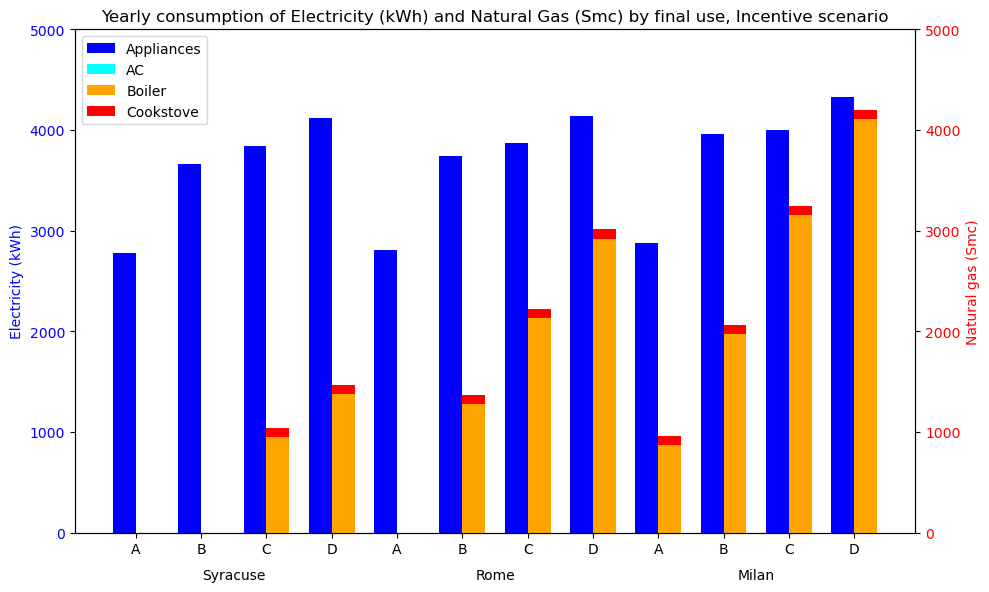

In [6]:
#Definiamo la posizione delle barre
x = np.arange(len(inc_graph['users']))  # Posizioni per ogni utente
width = 0.35  # Larghezza delle barre

# Creiamo il grafico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Aggiungiamo le barre sovrapposte per l'elettricità
rects1 = ax1.bar(x - width/2, inc_graph['YEE'], width, label='Appliances', color='blue')
rects2 = ax1.bar(x - width/2, inc_graph['HP'], width, bottom=inc_graph['YEE'], label='AC', color='cyan')
ax1.set_ylabel('Electricity (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 5000)

# Aggiungiamo le barre sovrapposte per il gas
ax2 = ax1.twinx()
rects4 = ax2.bar(x + width/2, inc_graph['Boiler'], width, label='Boiler', color='orange')
rects5 = ax2.bar(x + width/2, inc_graph['Cooking'], width, bottom=inc_graph['Boiler'], label='Cookstove', color='red')
ax2.set_ylabel('Natural gas (Smc)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 5000)

# Aggiungiamo le etichette per gli utenti
ax1.set_xticks(x)
ax1.set_xticklabels(inc_graph['users'])

# Aggiungiamo le etichette delle città sotto le colonne
cities = ['Syracuse'] * 4 + ['Rome'] * 4 + ['Milan'] * 4
city_positions = [1.5, 5.5, 9.5]  # Posizioni medie per i gruppi di utenti di ogni città
city_labels = ['Syracuse', 'Rome', 'Milan']

# Aggiungiamo i nomi delle città sotto l'asse
for i, city in enumerate(city_labels):
    ax1.text(city_positions[i], -0.07, city, ha='center', va='top', transform=ax1.get_xaxis_transform())
# Aggiungiamo la legenda
handles1, labels1 = ax1.get_legend_handles_labels()  # Otteniamo le barre di ax1 (elettricità)
handles2, labels2 = ax2.get_legend_handles_labels()  # Otteniamo le barre di ax2 (gas)

# Creiamo una legenda combinata in ax1
ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper left')

# Titolo e layout
plt.title('Yearly consumption of Electricity (kWh) and Natural Gas (Smc) by final use, Incentive scenario')
fig.tight_layout()

# Mostriamo il grafico
plt.show()


In [ ]:
# Definiamo la posizione delle barre
x = np.arange(len(df_CO2_act['users']))  # Posizioni per ogni utente
width = 0.35  # Larghezza delle barre

# Creiamo il grafico
fig, ax = plt.subplots(figsize=(10, 6))

# Aggiungiamo le barre sovrapposte per l'elettricità
rects1 = ax.bar(x - width/2, df_CO2_act['EE'], width, label='Electricity', color='#98DDF4')
rects2 = ax.bar(x - width/2, df_CO2_act['gas'], width, bottom=df_CO2_act['EE'], label='Natural Gas', color='#F6B85A')

# Aggiungiamo le etichette per gli utenti
ax.set_xticks(x)
ax.set_xticklabels(df_CO2_act['users'])

# Aggiungiamo le etichette delle città sotto le colonne
cities = ['Syracuse'] * 4 + ['Rome'] * 4 + ['Milan'] * 4
city_positions = [1.5, 5.5, 9.5]  # Posizioni medie per i gruppi di utenti di ogni città
city_labels = ['Syracuse', 'Rome', 'Milan']

# Aggiungiamo i nomi delle città sotto l'asse
for i, city in enumerate(city_labels):
    ax.text(city_positions[i], -0.07, city, ha='center', va='top', transform=ax.get_xaxis_transform())


# Aggiungiamo la legenda
ax.legend()
ax.set_ylabel('CO2eq (kg)')

# Titolo e layout
plt.title('CO2eq emissions (kg) for 1 year of operation, by energy carrier')
fig.tight_layout()

# Mostriamo il grafico
plt.show()

In [ ]:
X_AC_tot+ Y_EE_tot